In [56]:
# prep: import modules and get pwd
import pymysql
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [57]:
# connect to sql
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [58]:
query = '''
SELECT f.rental_rate, f.rating, f.length, f.special_features, fc.category_id
,(
SELECT count(*) FROM rental JOIN inventory USING (inventory_id) 
WHERE inventory.film_id = f.film_id
AND rental_date BETWEEN '2005-05-01' AND '2005-05-31'
) AS rented_in_may

FROM film f
JOIN film_category fc USING (film_id)
;
'''

data = pd.read_sql(query, engine)
data_actor = pd.read_sql('film_actor', engine)

In [59]:
pd.get_dummies(data_actor[['actor_id','film_id']], columns=['actor_id'])['film_id'].nunique()

#Wanted to One Hote Encode the actors in each film, turns out there are some films missing in the film_actor table

997

In [68]:
# change the last column to appropriate target values True or False

data['rented_in_may'] = np.where(data['rented_in_may'] == 0, False, True)
data

,rental_rate,rating,length,special_features,category_id,rented_in_may
0,0.99,PG,113,"Commentaries,Deleted Scenes,Behind the Scenes",1,True
1,4.99,R,129,"Commentaries,Behind the Scenes",1,True
2,2.99,NC-17,168,"Trailers,Commentaries,Deleted Scenes",1,False
3,0.99,NC-17,68,"Trailers,Commentaries,Deleted Scenes,Behind th...",1,False
4,2.99,G,129,"Trailers,Commentaries",1,True
...,...,...,...,...,...,...
995,0.99,PG-13,48,"Trailers,Behind the Scenes",16,True
996,2.99,R,85,"Deleted Scenes,Behind the Scenes",16,False
997,0.99,NC-17,55,Behind the Scenes,16,False
998,2.99,R,139,"Trailers,Commentaries,Behind the Scenes",16,False


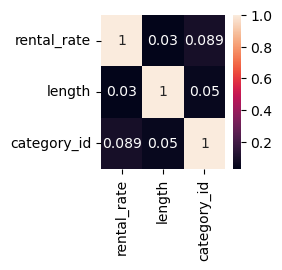

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix=data.select_dtypes('number').corr()  # default
fig, ax = plt.subplots(figsize=(2, 2))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

# The multicolinearity check got acceptable results, none of the numerical features need to be attended

In [65]:
y = data['rented_in_may']
X = data.drop('rented_in_may', axis=1)

X['category_id'] = X['category_id'].astype('object')

In [66]:
encoded_features = X['special_features'].str.get_dummies(sep=',') # Pure Magic, never imagined .get_dummies could work like this. Source: https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list

In [67]:
X = pd.concat([X.drop('special_features',axis=1), encoded_features],axis=1)
X

,rental_rate,rating,length,category_id,Behind the Scenes,Commentaries,Deleted Scenes,Trailers
0,0.99,PG,113,1,1,1,1,0
1,4.99,R,129,1,1,1,0,0
2,2.99,NC-17,168,1,0,1,1,1
3,0.99,NC-17,68,1,1,1,1,1
4,2.99,G,129,1,0,1,0,1
...,...,...,...,...,...,...,...,...
995,0.99,PG-13,48,16,1,0,0,1
996,2.99,R,85,16,1,0,1,0
997,0.99,NC-17,55,16,1,0,0,0
998,2.99,R,139,16,1,1,0,1


In [78]:
X['rental_rate'].value_counts()
# from the count of unique values of rental_rate, it turns out there's only three unique values, so might just encode this as well

rental_rate
0.99    341
4.99    336
2.99    323
Name: count, dtype: int64

In [ ]:
X = pd.get_dummies(X, columns=['rental_rate', 'rating','category_id']) # Encoding rental_rate, rating and category_id is easier

In [85]:
# since we're only left with one numeric feature, there's no need to normalize it

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

classification = LogisticRegression(random_state=0, max_iter='1000', solver='lbfgs').fit(X_train, y_train)

InvalidParameterError: The 'max_iter' parameter of LogisticRegression must be an int in the range [0, inf). Got '1000' instead.